In [2]:
import torch

In [3]:
import torchvision

In [4]:
import torchvision.transforms as transforms

In [5]:
import numpy as np

In [6]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [7]:
#The compose function allows for multiple transforms
#transforms.ToTensor() converts our PILImage to a tensor of shape (C x H x W) in the range [0,1]
#transforms.Normalize(mean,std) normalizes a tensor to a (mean, std) for (R, G, B)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./cifardata', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

 ship  ship  bird horse


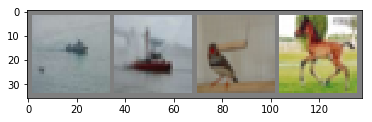

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [11]:
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 32, 32) to (18, 16, 16)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 16 *16)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [12]:
def outputSize(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1

    return(output)

In [13]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
    return(train_loader)

In [14]:
#Test and validation loaders have constant batch sizes, so we can define them directly
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

In [15]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [16]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data[0]
            total_train_loss += loss_size.data[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data[0]
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [17]:
CNN = SimpleCNN()
trainNet(CNN, batch_size=32, n_epochs=5, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 5
learning_rate= 0.001


C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 10% 	 train_loss: 2.13 took: 8.44s
Epoch 1, 20% 	 train_loss: 1.90 took: 3.09s
Epoch 1, 30% 	 train_loss: 1.71 took: 2.90s
Epoch 1, 40% 	 train_loss: 1.65 took: 2.96s
Epoch 1, 50% 	 train_loss: 1.56 took: 2.96s
Epoch 1, 60% 	 train_loss: 1.54 took: 2.79s
Epoch 1, 70% 	 train_loss: 1.46 took: 2.99s
Epoch 1, 80% 	 train_loss: 1.45 took: 3.02s
Epoch 1, 90% 	 train_loss: 1.39 took: 2.74s


C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation loss = 1.33
Epoch 2, 10% 	 train_loss: 1.32 took: 8.16s
Epoch 2, 20% 	 train_loss: 1.33 took: 3.91s
Epoch 2, 30% 	 train_loss: 1.27 took: 4.15s
Epoch 2, 40% 	 train_loss: 1.30 took: 3.61s
Epoch 2, 50% 	 train_loss: 1.25 took: 3.31s
Epoch 2, 60% 	 train_loss: 1.27 took: 3.34s
Epoch 2, 70% 	 train_loss: 1.30 took: 3.37s
Epoch 2, 80% 	 train_loss: 1.25 took: 3.44s
Epoch 2, 90% 	 train_loss: 1.25 took: 3.30s
Validation loss = 1.27
Epoch 3, 10% 	 train_loss: 1.12 took: 8.23s
Epoch 3, 20% 	 train_loss: 1.13 took: 3.28s
Epoch 3, 30% 	 train_loss: 1.13 took: 3.41s
Epoch 3, 40% 	 train_loss: 1.13 took: 3.39s
Epoch 3, 50% 	 train_loss: 1.16 took: 3.33s
Epoch 3, 60% 	 train_loss: 1.13 took: 3.34s
Epoch 3, 70% 	 train_loss: 1.15 took: 3.36s
Epoch 3, 80% 	 train_loss: 1.18 took: 3.50s
Epoch 3, 90% 	 train_loss: 1.14 took: 3.37s
Validation loss = 1.18
Epoch 4, 10% 	 train_loss: 1.02 took: 8.36s
Epoch 4, 20% 	 train_loss: 1.02 took: 3.33s
Epoch 4, 30% 	 train_loss: 1.07 took: 3.33s
Epoch 4

In [22]:
CNN

SimpleCNN(
  (conv1): Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

GroundTruth:    cat  ship  ship plane


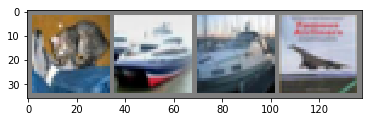

In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
outputss=CNN(images)

In [87]:
outputss

tensor([[-1.2995, -2.9127, -1.9791,  3.8283, -1.1985,  1.4808,  0.3422, -1.9791,
          0.9524, -0.9883],
        [ 5.0634,  5.8446, -2.0959, -2.8254, -3.3452, -6.2351, -6.5705, -7.3737,
          7.0277,  2.2735],
        [ 2.2431,  3.2895, -1.1895, -0.4353, -2.4037, -2.7561, -5.0246, -2.2916,
          3.5242,  1.8942],
        [ 3.4626,  0.3240,  1.7702, -1.7610, -1.1258, -4.2789, -3.0989, -4.6687,
          4.8347, -1.4147]], grad_fn=<ThAddmmBackward>)

In [21]:
_, predicted = torch.max(outputss, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane  ship


In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs =CNN(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 58 %
Accuracy of  bird : 49 %
Accuracy of   cat : 28 %
Accuracy of  deer : 60 %
Accuracy of   dog : 48 %
Accuracy of  frog : 71 %
Accuracy of horse : 69 %
Accuracy of  ship : 67 %
Accuracy of truck : 62 %


In [24]:
images.shape

torch.Size([4, 3, 32, 32])